# Importy

In [ ]:
!pip install se

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for se: filename=SE-2.3-py3-none-any.whl size=68957 sha256=b743dd9450b29e1b3c8200b4e8d3391b91ecdb248ad7f7cc1bee8f0022dafdf2
  Stored in directory: /root/.cache/pip/wheels/da/89/5f/a1c3a38846a1e861f1c57e1de1e706f3539d304c67b138b922
Successfully built se


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# Pre-processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Studia/Magisterka/for_training_songs_data.csv")

In [4]:
df.describe()

,valence,energy,Country,HipHop,Indie,Jazz,HeavyMetal,Rock,Pop,Rap,Sentiment,Lyric_Length,Unique_Words
count,5975.000000,5975.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000,133211.000000
mean,0.510612,0.484179,0.109135,0.157059,0.178491,0.134261,0.209277,0.190457,0.211341,0.111417,0.198335,567.558873,71.165489
std,0.250718,0.243538,0.311810,0.363858,0.382927,0.340977,0.406812,0.392682,0.408280,0.314649,0.898333,513.151659,54.383067
min,0.012881,0.004343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,1.000000
25%,0.306987,0.289267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.958900,194.000000,39.000000
50%,0.510511,0.466450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.862500,411.000000,55.000000
75%,0.717642,0.677668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.993400,776.000000,79.000000
max,0.990725,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,8311.000000,735.000000


In [5]:
df.rename(columns={'HeavyMetal': 'Metal', 'HipHop':'Hip-Hop'}, inplace=True)

In [6]:
LABEL_COLUMNS = ['Country', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Rock', 'Pop', 'Rap']

# Take only lyrics that have one genre
df = df[df[LABEL_COLUMNS].sum(axis=1) == 1]

In [ ]:
# Make df genres alphabetically sorted - only LABEL_COLUMNS
#df[LABEL_COLUMNS] = df[LABEL_COLUMNS].apply(lambda x: x.sort_index(), axis=1)

In [ ]:
df

,Artist,SName,Lyric,valence,energy,Country,Hip-Hop,Indie,Jazz,Metal,Rock,Pop,Rap,Lyric_Lemmatized,Lyric_Stemmed,Lyric_Lemmatized_NoStop,Sentiment,Lyric_Length,Unique_Words
0,audrye sessions,contagious,leave now while you can because growing old ju...,NaN,NaN,0,0,1,0,0,0,0,0,leave now while you can because growing old ju...,leav now while you can becaus grow old just in...,leave growing old intoxicates mind word drip l...,-0.9201,138,18
1,audrye sessions,dust and bones,we have been poisoned tracked down herded to s...,NaN,NaN,0,0,1,0,0,0,0,0,we have been poisoned tracked down herded to s...,we have been poison track down herd to stand b...,poisoned tracked herded stand behind mind one ...,0.9780,191,51
2,audrye sessions,new year's day,the needles in hand but i cannot sew my hearts...,NaN,NaN,0,0,1,0,0,0,0,0,the needle s in hand but i can not sew my hear...,the needl s in hand but i can not sew my heart...,needle s hand sew heart s worn thing like swea...,-0.5647,233,47
3,audrye sessions,perfect sometimes,i catch every whisper surrounding your head yo...,NaN,NaN,0,0,1,0,0,0,0,0,i catch every whisper surrounding your head yo...,i catch everi whisper surround your head you g...,catch every whisper surrounding head got look ...,-0.9803,194,62
4,audrye sessions,relentless,get off of work come home pass out my lifes be...,NaN,NaN,0,0,1,0,0,0,0,0,get off of work come home pas out my life s be...,get off of work come home pass out my life s b...,get work come home pas life s become cancer cr...,-0.9429,256,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133205,Troye Sivan,​could cry just thinkin about you,now i am kneedeep in this mess i could cry jus...,NaN,NaN,0,0,1,0,0,0,0,0,now i am kneedeep in this mess i could cry jus...,now i am kneedeep in thi mess i could cri just...,kneedeep mess could cry thinking every line wr...,-0.2703,71,23
133206,Danny Brown,​uknowhatimsayin¿ (Ft. Obongjayar),clock tickin know you cannot be playin know wh...,NaN,NaN,0,1,0,0,0,0,0,0,clock tickin know you can not be playin know...,clock tickin know you can not be playin know...,clock tickin know playin know sayin got get...,0.5930,370,67
133207,Taylor Swift,​willow (Dancing witch version) (Elvira remix),i am like the water when your ship rolled in t...,NaN,NaN,0,0,0,0,0,0,1,0,i am like the water when your ship rolled in t...,i am like the water when your ship roll in tha...,like water ship rolled night rough surface cut...,0.9982,1298,81
133208,Fleet Foxes,"– Naiads, Cassadies",the storm suddenly breaks in a car on the coas...,NaN,NaN,0,0,1,0,0,0,0,0,the storm suddenly break in a car on the coast...,the storm suddenli break in a car on the coast...,storm suddenly break car coast stole life turn...,0.5312,179,36


In [ ]:
df.describe()

,valence,energy,Country,Hip-Hop,Indie,Jazz,Metal,Rock,Pop,Rap,Sentiment,Lyric_Length,Unique_Words
count,5975.000000,5975.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000,94259.000000
mean,0.510612,0.484179,0.119882,0.078677,0.163231,0.182731,0.186327,0.027191,0.214197,0.027764,0.256507,427.645657,63.037567
std,0.250718,0.243538,0.324826,0.269235,0.369578,0.386448,0.389372,0.162641,0.410266,0.164297,0.868268,398.251423,44.594053
min,0.012881,0.004343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,1.000000
25%,0.306987,0.289267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.893500,155.000000,37.000000
50%,0.510511,0.466450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880100,283.000000,52.000000
75%,0.717642,0.677668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991900,578.000000,72.000000
max,0.990725,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7111.000000,663.000000


In [8]:
df['genre'] = df[LABEL_COLUMNS].idxmax(axis=1)

In [ ]:
df

,Artist,SName,Lyric,valence,energy,Country,Hip-Hop,Indie,Jazz,Metal,Rock,Pop,Rap,Lyric_Lemmatized,Lyric_Stemmed,Lyric_Lemmatized_NoStop,Sentiment,Lyric_Length,Unique_Words,genre
0,audrye sessions,contagious,leave now while you can because growing old ju...,NaN,NaN,0,0,1,0,0,0,0,0,leave now while you can because growing old ju...,leav now while you can becaus grow old just in...,leave growing old intoxicates mind word drip l...,-0.9201,138,18,Indie
1,audrye sessions,dust and bones,we have been poisoned tracked down herded to s...,NaN,NaN,0,0,1,0,0,0,0,0,we have been poisoned tracked down herded to s...,we have been poison track down herd to stand b...,poisoned tracked herded stand behind mind one ...,0.9780,191,51,Indie
2,audrye sessions,new year's day,the needles in hand but i cannot sew my hearts...,NaN,NaN,0,0,1,0,0,0,0,0,the needle s in hand but i can not sew my hear...,the needl s in hand but i can not sew my heart...,needle s hand sew heart s worn thing like swea...,-0.5647,233,47,Indie
3,audrye sessions,perfect sometimes,i catch every whisper surrounding your head yo...,NaN,NaN,0,0,1,0,0,0,0,0,i catch every whisper surrounding your head yo...,i catch everi whisper surround your head you g...,catch every whisper surrounding head got look ...,-0.9803,194,62,Indie
4,audrye sessions,relentless,get off of work come home pass out my lifes be...,NaN,NaN,0,0,1,0,0,0,0,0,get off of work come home pas out my life s be...,get off of work come home pass out my life s b...,get work come home pas life s become cancer cr...,-0.9429,256,45,Indie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133205,Troye Sivan,​could cry just thinkin about you,now i am kneedeep in this mess i could cry jus...,NaN,NaN,0,0,1,0,0,0,0,0,now i am kneedeep in this mess i could cry jus...,now i am kneedeep in thi mess i could cri just...,kneedeep mess could cry thinking every line wr...,-0.2703,71,23,Indie
133206,Danny Brown,​uknowhatimsayin¿ (Ft. Obongjayar),clock tickin know you cannot be playin know wh...,NaN,NaN,0,1,0,0,0,0,0,0,clock tickin know you can not be playin know...,clock tickin know you can not be playin know...,clock tickin know playin know sayin got get...,0.5930,370,67,Hip-Hop
133207,Taylor Swift,​willow (Dancing witch version) (Elvira remix),i am like the water when your ship rolled in t...,NaN,NaN,0,0,0,0,0,0,1,0,i am like the water when your ship rolled in t...,i am like the water when your ship roll in tha...,like water ship rolled night rough surface cut...,0.9982,1298,81,Pop
133208,Fleet Foxes,"– Naiads, Cassadies",the storm suddenly breaks in a car on the coas...,NaN,NaN,0,0,1,0,0,0,0,0,the storm suddenly break in a car on the coast...,the storm suddenli break in a car on the coast...,storm suddenly break car coast stole life turn...,0.5312,179,36,Indie


In [9]:
from sklearn.preprocessing import LabelEncoder

# Prepare labels
y = df['genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = np.eye(len(label_encoder.classes_))[y]  # One-hot encode genres
print(label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(df['Lyric_Lemmatized'], y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shape of the splits
print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

['Country' 'Hip-Hop' 'Indie' 'Jazz' 'Metal' 'Pop' 'Rap' 'Rock']
Training set: 75407 samples
Validation set: 9426 samples
Test set: 9426 samples


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")  # You can replace this with your desired model
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", output_hidden_states=True)
model = model.to(device)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class LyricsGenreDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.tolist()
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label,
        }

In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")
model = RobertaForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=8,
).to(device)

# Create datasets and dataloaders
batch_size = 24

train_dataset = LyricsGenreDataset(X_train, y_train, tokenizer)
val_dataset = LyricsGenreDataset(X_val, y_val, tokenizer)
test_dataset = LyricsGenreDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss and optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def train_model_single_genre(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=3):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Train loss: {train_loss}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Training Loss: {train_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                # Convert multi-label predictions into single genre predictions
                val_preds.extend(np.argmax(torch.sigmoid(outputs.logits).cpu().numpy(), axis=1))
                val_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="macro")
        print(f"Validation Loss: {val_loss / len(val_loader)}")
        print(f"Validation Accuracy: {val_accuracy}")
        print(f"Validation F1 Score: {val_f1}")

# Train the model
train_model_single_genre(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=3)

Epoch 1/3


Train loss: 0: 100%|██████████| 3142/3142 [59:42<00:00,  1.14s/it]


Training Loss: 0.211116717738247
Validation Loss: 0.18706066614495587
Validation Accuracy: 0.6789730532569489
Validation F1 Score: 0.6119845848988488
Epoch 2/3


Train loss: 0: 100%|██████████| 3142/3142 [59:40<00:00,  1.14s/it]


Training Loss: 0.1683527443825933
Validation Loss: 0.19363022752997225
Validation Accuracy: 0.6622109060046679
Validation F1 Score: 0.5788709706753192
Epoch 3/3


Train loss: 0: 100%|██████████| 3142/3142 [59:41<00:00,  1.14s/it]


Training Loss: 0.1415709347803831
Validation Loss: 0.1865421738902121
Validation Accuracy: 0.6970082749840866
Validation F1 Score: 0.6438084237972033


In [ ]:
# Save model to pk file
torch.save(model.state_dict(), "/content/drive/MyDrive/Studia/Master thesis/BertLyrics/lyrics_genre_model_alphabetically.pt")

In [ ]:
# Load the saved model
model = RobertaForSequenceClassification.from_pretrained(
    "distilroberta-base",
    num_labels=8
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Studia/Master thesis/BertLyrics/lyrics_genre_model_alphabetically.pt"))
model.to(device)
model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-dd58ce2e9ceb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [ ]:
test_dataset.labels

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
LABEL_COLUMNS

['Country', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Rock', 'Pop', 'Rap']

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_model_single_genre(model, test_loader, device):
    model.eval()
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            # Get probabilities
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            test_probs.extend(probs)

            test_preds.extend(np.argmax(probs, axis=1))
            test_labels.extend(np.argmax(labels.cpu().numpy(), axis=1))

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="macro")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1}")

    return test_labels, test_preds, test_probs

# Run evaluation and get predictions and labels
test_labels, test_preds, test_probs = evaluate_model_single_genre(model, test_loader, device)

print(classification_report(test_labels, test_preds, target_names=list(label_encoder.classes_)))

Test Accuracy: 0.7058137067685126
Test F1 Score: 0.6488487838957624
              precision    recall  f1-score   support

     Country       0.78      0.64      0.70      1157
     Hip-Hop       0.66      0.53      0.59       774
       Indie       0.61      0.64      0.63      1523
        Jazz       0.74      0.78      0.76      1641
       Metal       0.83      0.84      0.84      1771
         Pop       0.66      0.75      0.70      2020
         Rap       0.53      0.62      0.57       260
        Rock       0.60      0.31      0.41       280

    accuracy                           0.71      9426
   macro avg       0.68      0.64      0.65      9426
weighted avg       0.71      0.71      0.70      9426



In [ ]:
from sklearn.metrics import classification_report

def classification_report_single_genre(test_preds, test_labels):
    print(classification_report(test_labels, test_preds, target_names=list(label_encoder.classes_)))

# Use this function as needed to print the classification report
classification_report_single_genre(test_preds, test_labels)

In [10]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

In [16]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["white", "#455681"]  # White to #455681 gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_white_to_blue", colors)

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_single_confusion_matrix(test_labels, test_preds, label_names):
    cm = confusion_matrix(test_labels, test_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Use latex
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot Non-Normalized
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Non-Normalized)")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Plot Normalized
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=custom_cmap, xticklabels=label_names, yticklabels=label_names, vmax=1.0)
    plt.ylabel("True", fontdict={"fontsize": 12})
    plt.xlabel("Predicted", fontdict={"fontsize": 12})
    # Save as png
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Studia/Master thesis/BertLyrics/confusion_matrix_normalized_2.eps", dpi=300)
    plt.show()

# Plot single confusion matrix
plot_single_confusion_matrix(test_labels, test_preds, list(label_encoder.classes_))




NameError: name 'test_labels' is not defined

In [ ]:
from scipy.stats import ttest_rel, wilcoxon
import numpy as np
import pandas as pd

df = pd.read_csv("/content/results.csv", delimiter=';')
# Example genre-wise F1-scores



In [ ]:
df

,genre,early_fusion,late_fusion,lyrics,metadata,audio
0,Country,0.03,0.55,0.11,0.06,0.20
1,Hip-Hop,0.18,0.69,0.23,0.05,0.56
2,Indie,0.46,0.46,0.43,0.11,0.25
3,Jazz,0.77,0.70,0.78,0.53,0.50
4,Metal,0.62,0.80,0.52,0.44,0.64
5,Pop,0.19,0.58,0.04,0.35,0.34
6,Rap,0.71,0.73,0.67,0.47,0.65
7,Rock,0.35,0.60,0.00,0.33,0.53


In [ ]:
late_fusion_scores = df['late_fusion'].values
early_fusion_scores = df['early_fusion'].values
lyrics_scores = df['lyrics'].values
audio_scores = df['audio'].values
metadata_scores = df['metadata'].values

In [18]:
# prompt: Make a grouped bar chart

import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
genres = df['genre'].values
late_fusion_scores = df['early_fusion'].values
early_fusion_scores = df['late_fusion'].values
lyrics_scores = df['lyrics'].values
audio_scores = df['audio'].values
metadata_scores = df['metadata'].values


# Set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(14, 8))

# Set position of bar on X axis
br1 = np.arange(len(genres))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]


# Make the plot
plt.bar(br1, late_fusion_scores, color =colors[0], width = barWidth, label ='Late Fusion')
plt.bar(br2, early_fusion_scores, color =colors[1], width = barWidth,label ='Early Fusion')
plt.bar(br3, lyrics_scores, color =colors[2], width = barWidth, label ='Lyrics')
plt.bar(br4, audio_scores, color =colors[3], width = barWidth, label ='Audio')
plt.bar(br5, metadata_scores, color =colors[4], width = barWidth, label ='Metadata')

# Adding Xticks
plt.xlabel('Genres', fontweight ='bold', fontsize = 16)
plt.ylabel('F1-Score', fontweight ='bold', fontsize = 16)
plt.xticks([r + barWidth for r in range(len(genres))],
        genres, fontsize=14)

plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("grouped_bar_chart.eps", dpi=300)
plt.show()

KeyError: 'early_fusion'

In [ ]:


# Compare Late Fusion with other models
print("Late Fusion vs Lyrics Model:")

stat, p_value = wilcoxon(late_fusion_scores, lyrics_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")

stat, p_value = wilcoxon(late_fusion_scores, audio_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")

stat, p_value = wilcoxon(late_fusion_scores, metadata_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")


stat, p_value = wilcoxon(early_fusion_scores, lyrics_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")

stat, p_value = wilcoxon(early_fusion_scores, audio_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")

stat, p_value = wilcoxon(early_fusion_scores, metadata_scores)
print(f"Wilcoxon Test: statistic = {stat}, p-value = {p_value}")


Late Fusion vs Lyrics Model:
Wilcoxon Test: statistic = 3.0, p-value = 0.0390625
Wilcoxon Test: statistic = 0.0, p-value = 0.0078125
Wilcoxon Test: statistic = 0.0, p-value = 0.0078125
Wilcoxon Test: statistic = 10.0, p-value = 0.3125
Wilcoxon Test: statistic = 15.0, p-value = 0.7421875
Wilcoxon Test: statistic = 6.0, p-value = 0.109375


<Figure size 1000x2000 with 0 Axes>

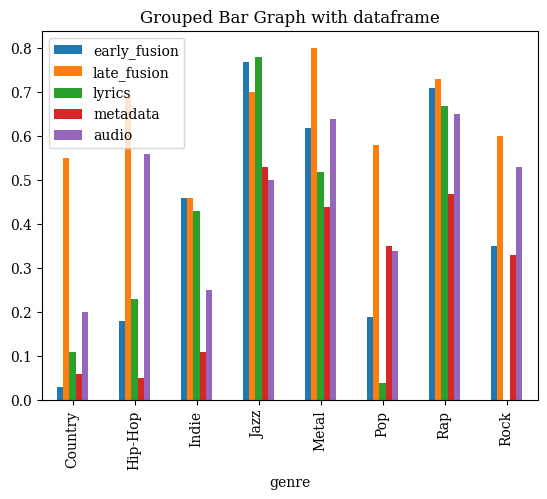

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Team A', 'Team B', 'Team C', 'Team D', 'Team E'])
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.legend(["Round 1", "Round 2", "Round 3"])
plt.show()

In [19]:
# Print auc-roc curve for each class on one plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Run evaluation and get predictions, labels, and probabilities

# Get the true positive rate and false positive rate
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):  # Assuming 8 classes
    fpr[i], tpr[i], _ = roc_curve((np.array(test_labels) == i).astype(int), np.array(test_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")  # Use label_encoder.classes_ for genre names
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontdict={"fontsize": 12})
plt.ylabel("True Positive Rate",  fontdict={"fontsize": 12})
plt.legend(loc="lower right", prop={"size": 12})  # Adjust legend location if needed
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.style.use('fast')
plt.tight_layout()
# Save as png

plt.savefig("/content/drive/MyDrive/Studia/Master thesis/BertLyrics/auc_roc_roberta.eps", dpi=300)

plt.show()





NameError: name 'test_labels' is not defined

<class 'list'>


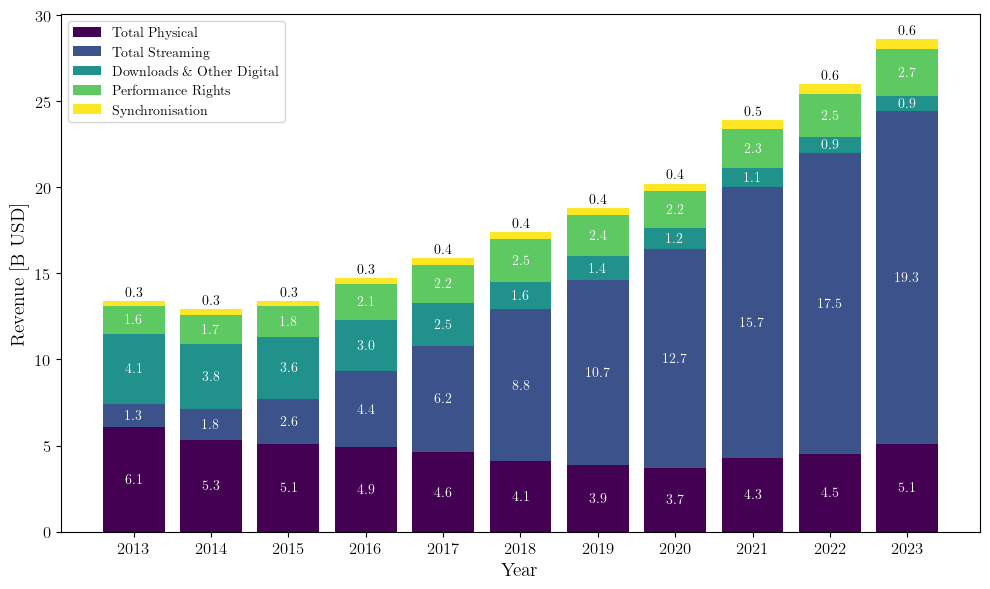

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

data = [
    [6.1, 1.3, 4.1, 1.6, 0.3, 2013],  # 2013
    [5.3, 1.8, 3.8, 1.7, 0.3, 2014],  # 2014
    [5.1, 2.6, 3.6, 1.8, 0.3, 2015],  # 2015
    [4.9, 4.4, 3.0, 2.1, 0.3, 2016],  # 2016
    [4.6, 6.2, 2.5, 2.2, 0.4, 2017],  # 2017
    [4.1, 8.8, 1.6, 2.5, 0.4, 2018],  # 2018
    [3.9, 10.7, 1.4, 2.4, 0.4, 2019],  # 2019
    [3.7, 12.7, 1.2, 2.2, 0.4, 2020],  # 2020
    [4.3, 15.7, 1.1, 2.3, 0.5, 2021],  # 2021
    [4.5, 17.5, 0.9, 2.5, 0.6, 2022],  # 2022
    [5.1, 19.3, 0.9, 2.7, 0.6, 2023],  # 2023
]

columns = ["Total Physical", "Total Streaming", "Downloads \& Other Digital", "Performance Rights", "Synchronisation", "Year"]

df = pd.DataFrame(data, columns = columns)

# Define the columns for the categories
categories = ["Total Physical", "Total Streaming", "Downloads \& Other Digital", "Performance Rights", "Synchronisation"]

# Set figure size
plt.figure(figsize=(10, 6))

plt.style.use('tableau-colorblind10')

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


import matplotlib as mpl
cmap = mpl.colormaps['viridis']
colors = cmap(np.linspace(0, 1, len(categories))).tolist() # Generate colors from colormap

# colors = random.sample(colors, len(colors))

print(type(colors))

# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot stacked bars
bottom_values = np.zeros(len(df))  # Initialize the bottom values for stacking
# Plot stacked bars and annotate
# Plot stacked bars and annotate
for i, category in enumerate(categories):
    plt.bar(df["Year"], df[category], bottom=bottom_values, color=colors[i], label=category )

    # Annotate the values
    for i, value in enumerate(df[category]):
        x = df["Year"][i]  # X-coordinate (year)
        if category == "Synchronisation":
            # Place above the bar
            y = bottom_values[i] + value + 0.5
        else:
            # Center the annotation within the bar segment
            y = bottom_values[i] + value / 2

        plt.text(x, y, str(value), ha='center', va='center', fontsize=10,
                 color='white' if category != "Synchronisation" else 'black',
                 fontweight='bold')

    # Update the bottom values
    bottom_values += df[category]

# Add labels, legend, and title
plt.xlabel("Year", fontdict={"fontsize":14})
plt.ylabel("Revenue [B USD]", fontdict={"fontsize":14})
plt.xticks(fontsize=12)

plt.yticks(fontsize=12)

plt.legend(loc="upper left")  # Legend outside the chart
plt.xticks(df["Year"])  # Ensure proper year labels on x-axis
plt.savefig("revenue_by_year.eps", dpi=300)
plt.tight_layout()
# Position legend left upper corner




# Show the plot
plt.show()

In [ ]:
df

,Total Physical,Total Streaming,Downloads & Other Digital,Performance Rights,Synchronisation,Year
0,6.1,1.3,4.1,1.6,0.3,2013
1,5.3,1.8,3.8,1.7,0.3,2014
2,5.1,2.6,3.6,1.8,0.3,2015
3,4.9,4.4,3.0,2.1,0.3,2016
4,4.6,6.2,2.5,2.2,0.4,2017
5,4.1,8.8,1.6,2.5,0.4,2018
6,3.9,10.7,1.4,2.4,0.4,2019
7,3.7,12.7,1.2,2.2,0.4,2020
8,4.3,15.7,1.1,2.3,0.5,2021
9,4.5,17.5,0.9,2.5,0.6,2022


In [ ]:
# Stacked bar plot by year of different music revenue types
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Differnt color by column




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = "/content/data_one_genre_with_extracted_features_full.npy"
data = np.load(path, allow_pickle=True)

In [ ]:
df = pd.DataFrame(data, columns = ['genre', 'z_cross_rate'])

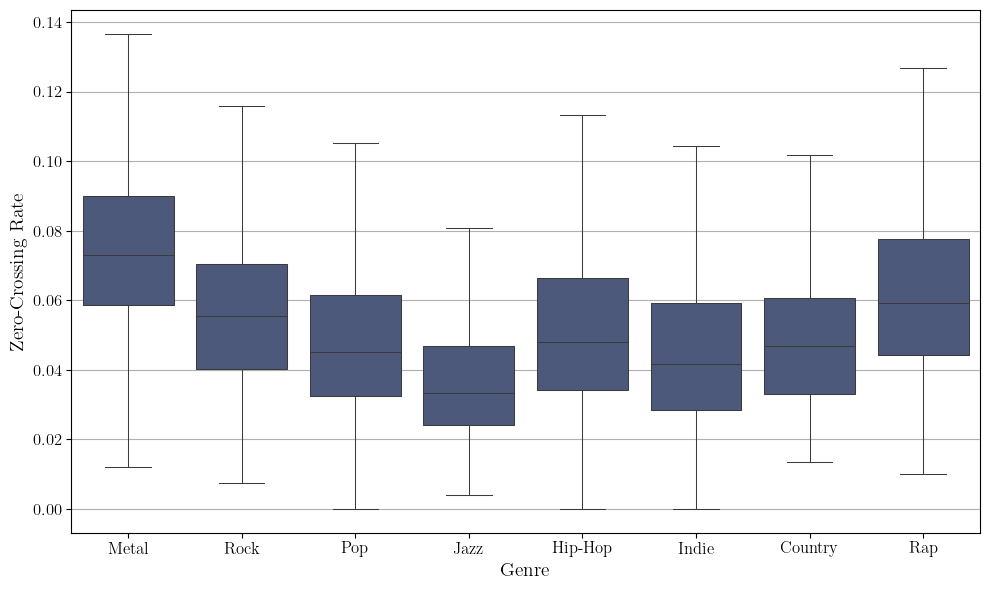

In [ ]:
# Boxplot of zerocrossing rate by genre

plt.figure(figsize=(10, 6))


import matplotlib as mpl
cmap = mpl.colormaps['viridis']
#colors = cmap(np.linspace(0, 1, len(categories))).tolist() # Generate colors from colormap

# Select random color from colors
#colors = random.sample(colors, len(colors))

# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# With plt.boxplot, don't show outliers order by genre alphabetically
sns.boxplot(x=df['genre'].str.capitalize().apply(lambda x: 'Hip-Hop' if x == 'Hiphop' else x), y=df['z_cross_rate'], showfliers=False, fill=True, linewidth=.75, color="#455681")
plt.xlabel('Genre', fontdict={"fontsize":14})
plt.ylabel('Zero-Crossing Rate', fontdict={"fontsize":14})
plt.xticks(fontsize=12)

plt.yticks(fontsize=12)

plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('tempo_by_genre.eps', dpi=300)
plt.show()


In [ ]:
#distilBERT, miniLM, nie finetuningowac - wektoryzacje tylko zrobić i na tym klasyfikacje, sentence transfr,

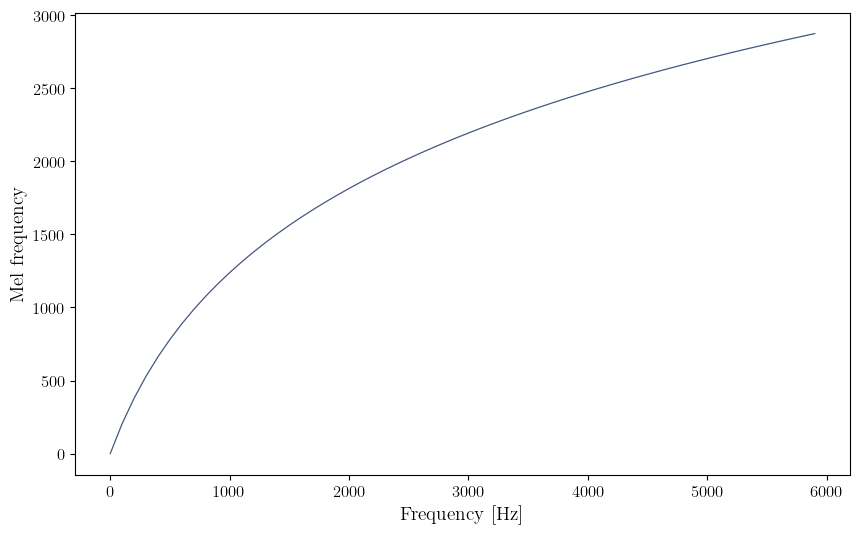

In [ ]:
# Draw plot of Mel-scale mel frequency (Y) vs frequency (X)
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import math

np.log

frequency_range = np.arange(0, 6000, 100)
def m(f):
  return 2595 * np.log10(1+f/500)

mel_frequency_range = m(frequency_range)

# Plot
plt.figure(figsize=(10, 6))

# Use latex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(frequency_range, mel_frequency_range, linestyle='-', linewidth=.9, color="#455681")

# Make x ticks in kHz from Hz
plt.xticks(fontsize=12)

plt.yticks(fontsize=12)


# Axis names
plt.xlabel('Frequency [Hz]', fontdict={"fontsize":14})
plt.ylabel('Mel frequency', fontdict={"fontsize":14})

plt.savefig('mel_frequency_range.eps', dpi=300)

plt.show()

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/data_one_genre_with_extracted_features_full.csv')

In [ ]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artist_id', 'album_id', 'duration', 'pop',
       'metal', 'rock', 'hiphop', 'rap', 'indie', 'jazz', 'country',
       'zero_crossing_rate', 'harmonic_mean', 'percussive_mean', 'tempo_bpm',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean',
       'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
       'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean',
       'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean',
       'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean',
       'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean',
       'chroma_11_mean', 'chroma_12_mean', 'stft_magnitude_mean', 'rms_mean'],
      dtype='object')

In [ ]:
# Check if all rows have only one genre so sum of pop+metal+rock+hiphop+rap+indie+jazz+country is not more than 1
genre_columns = ['pop', 'metal', 'rock', 'hiphop', 'rap', 'indie', 'jazz', 'country']
df['sum_genres'] = df[genre_columns].sum(axis=1)

# Check if not bigger than 1
if (df['sum_genres'] > 1).any():
    print("Not all rows have only one genre.")
else:
    print("All rows have only one genre.")

All rows have only one genre.


In [ ]:
# Create column 'genre' with assigned genre where value is 1 (not 0)
df['genre'] = df[genre_columns].idxmax(axis=1)

In [ ]:
df.genre.value_counts()

,count
genre,
pop,5200
rock,3457
jazz,1796
hiphop,1461
indie,1059
metal,885
country,435
rap,133


In [ ]:
# Count of unique tracks by genre, unique artist_id by genre, unique album_id by genre
df.groupby('genre').nunique()


,Unnamed: 0,track_id,artist_id,album_id,duration,pop,metal,rock,hiphop,rap,...,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,stft_magnitude_mean,rms_mean,sum_genres
genre,,,,,,,,,,,,,,,,,,,,,
country,433,435,86,136,392,1,1,1,1,1,...,435,435,435,435,435,435,435,435,435,1
hiphop,1416,1461,229,360,1030,1,1,1,1,1,...,1433,1433,1433,1433,1433,1433,1433,1433,1433,1
indie,1031,1059,206,338,845,1,1,1,1,1,...,1058,1058,1057,1058,1058,1058,1058,1058,1058,1
jazz,1712,1796,333,607,1406,1,1,1,1,1,...,1787,1786,1787,1787,1787,1786,1787,1787,1787,1
metal,872,885,148,230,753,1,1,1,1,1,...,885,885,884,885,885,884,885,885,885,1
pop,4349,5200,784,1617,2385,1,1,1,1,1,...,5159,5161,5159,5160,5161,5159,5161,5159,5160,1
rap,133,133,50,57,130,1,1,1,1,1,...,133,133,133,133,133,133,133,133,133,1
rock,3094,3457,722,1168,1993,1,1,1,1,1,...,3440,3439,3440,3440,3439,3440,3440,3440,3440,1


In [ ]:
fma = pd.read_csv('/content/fma_cut100_echonest_lyrics_fake_country.csv', header=[0,1])

In [ ]:
fma.columns

MultiIndex([( 'track',          'track_id'),
            ( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
          

In [ ]:
fma[[( 'track', 'track_id'),('artist', 'name_clean'),( 'album','id'),('track','one_genre')]].groupby(by=[('track','one_genre')]).nunique()

,track,artist,album
,track_id,name_clean,id
"(track, one_genre)",,,
Country,60,19,20
Hip-Hop,43,15,19
Indie,95,26,29
Jazz,82,38,40
Metal,51,18,14
Pop,100,49,53
Rap,46,7,8
Rock,100,45,49


In [21]:
# Plot AUC-ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr = np.load('/content/fpr_early.npy', allow_pickle=True).item()
tpr = np.load('/content/tpr_early.npy', allow_pickle=True).item()
roc_auc = np.load('/content/auc_roc_early.npy', allow_pickle=True).item()



In [22]:
fpr = {k: v.tolist() if v.ndim == 0 else v for k, v in fpr.items()}
tpr = {k: v.tolist() if v.ndim == 0 else v for k, v in tpr.items()}
roc_auc = {k: v.tolist() if isinstance(v, np.ndarray) and v.ndim == 0 else v for k, v in roc_auc.items()}

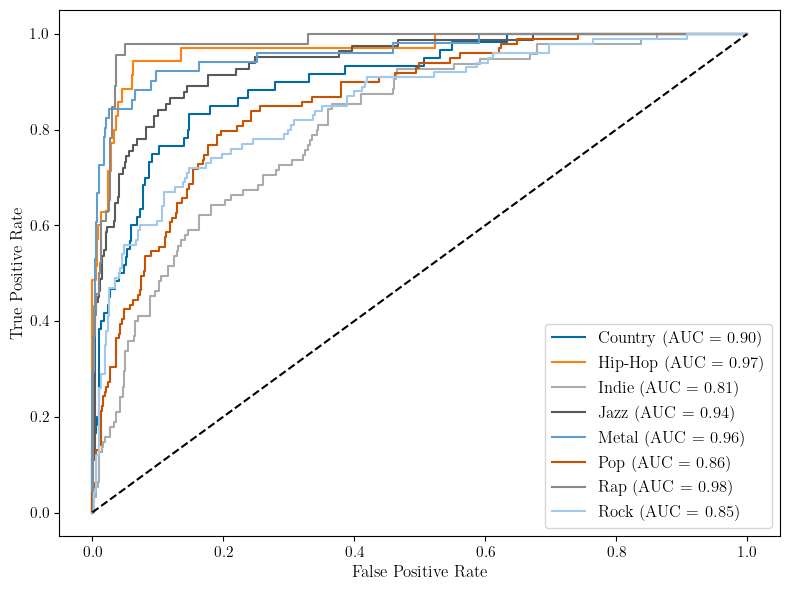

In [23]:
plt.figure(figsize=(8, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(8):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontdict={"fontsize": 12})
plt.ylabel("True Positive Rate", fontdict={"fontsize": 12})
# Make background plain white
plt.style.use('tableau-colorblind10')
# Add legend
plt.legend(fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.savefig("auc_roc_early_multi.eps", dpi=300)
plt.show()

In [ ]:
fpr

{0: array([0.        , 0.        , 0.        , 0.00393701, 0.00393701,
        0.01377953, 0.01377953, 0.02165354, 0.02165354, 0.03149606,
        0.03149606, 0.04133858, 0.04133858, 0.04724409, 0.04724409,
        0.05314961, 0.05314961, 0.06102362, 0.06102362, 0.06299213,
        0.06299213, 0.06496063, 0.06496063, 0.07874016, 0.07874016,
        0.08858268, 0.08858268, 0.09645669, 0.09645669, 0.0984252 ,
        0.0984252 , 0.10629921, 0.10629921, 0.11417323, 0.11417323,
        0.11614173, 0.11614173, 0.14566929, 0.14566929, 0.15944882,
        0.15944882, 0.16535433, 0.16535433, 0.18503937, 0.18503937,
        0.20275591, 0.20275591, 0.2519685 , 0.2519685 , 0.25393701,
        0.25393701, 0.27755906, 0.27755906, 0.31299213, 0.31299213,
        0.31889764, 0.31889764, 0.3523622 , 0.3523622 , 0.40551181,
        0.40551181, 0.42913386, 0.42913386, 0.43503937, 0.43503937,
        0.44291339, 0.44291339, 0.44488189, 0.44488189, 0.48622047,
        0.48622047, 0.49212598, 0.49212598, 0

In [ ]:
confusion_matrix = [[30,  0,  4,  9,  1, 12,  0,  4],
 [ 0, 21,  0,  1,  0,  0, 12,  1],
 [ 5 , 0, 39,  9,  4, 21,  0, 17],
 [ 5,  0,  4, 62,  2,  5,  0,  4],
 [ 0,  1,  1,  2 ,41,  3,  0 , 3],
 [ 8,  0, 12,  2,  2, 63,  2, 10],
 [ 0,  4,  0,  1,  1,  4, 36,  0],
 [ 2,  0, 16,  8,  1, 11,  2, 60]]


import numpy as np

cm = np.array(confusion_matrix)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# Plot with sns

# Plot Normalized
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=custom_cmap, xticklabels=label_names, yticklabels=label_names, vmax=1.0)
plt.ylabel("True", fontdict={"fontsize": 12})
plt.xlabel("Predicted", fontdict={"fontsize": 12})
# Save as png
plt.savefig("/content/drive/MyDrive/Studia/Master thesis/BertLyrics/confusion_matrix_normalized_early_fusion.eps", dpi=300)
plt.show()

In [ ]:
combined_probs = np.load("/content/combined_probs_weighted.npy")
y_lyrics = np.load("/content/y_lyrics_weighted.npy")


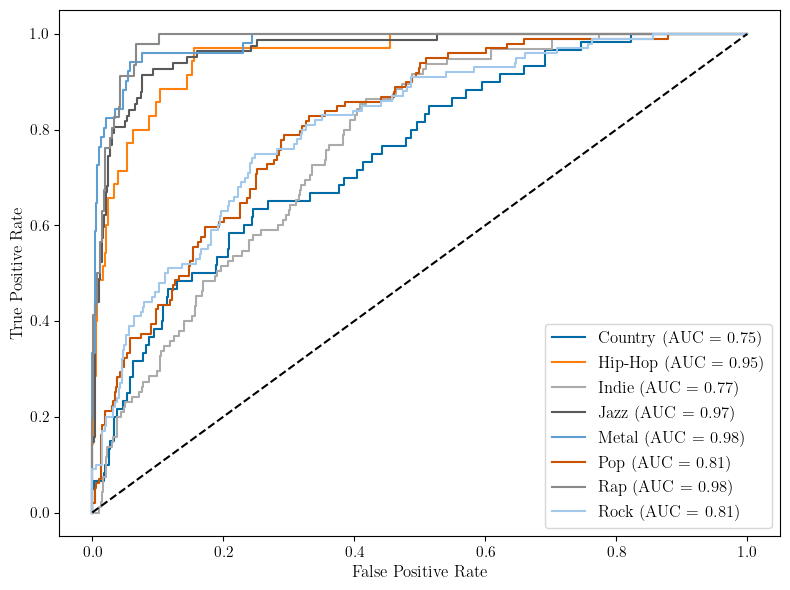

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8, 6))
for i in range(8):
    roc_auc = roc_auc_score(y_lyrics[:, i], combined_probs[:, i])
    fpr, tpr, _ = roc_curve(y_lyrics[:, i], combined_probs[:, i])
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontdict={"fontsize": 12})
plt.ylabel("True Positive Rate", fontdict={"fontsize": 12})
# Make background plain white
plt.style.use('fast')
# Add legend
plt.legend(fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.savefig("auc_roc_weighted_voting_multi.eps", dpi=300)
plt.show()